In [15]:
import gymnasium as gym
import numpy as np
import random
from collections import defaultdict
import time
import matplotlib.pyplot as plt
import pickle

In [16]:
# Environment Setup
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=True)
n_states = env.observation_space.n
n_actions = env.action_space.n

In [3]:
# Monte Carlo First-Visit Agent
class MonteCarloAgent:
    def __init__(self, n_states, n_actions, epsilon=0.1, gamma=0.99):
        self.Q = defaultdict(lambda: np.zeros(n_actions))
        self.returns = defaultdict(list)
        self.epsilon = epsilon
        self.gamma = gamma
        self.n_actions = n_actions

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(range(self.n_actions))
        return np.argmax(self.Q[state])

    def generate_episode(self, env):
        episode = []
        state, _ = env.reset()
        done = False
        while not done:
            action = self.choose_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            episode.append((state, action, reward))
            state = next_state
            done = terminated or truncated
        return episode

    def update(self, episode):
        G = 0
        visited = set()
        for i in reversed(range(len(episode))):
            state, action, reward = episode[i]
            G = self.gamma * G + reward
            if (state, action) not in visited:
                self.returns[(state, action)].append(G)
                self.Q[state][action] = np.mean(self.returns[(state, action)])
                visited.add((state, action))

# Training
agent = MonteCarloAgent(n_states, n_actions)
n_episodes = 50000
returns_per_episode = []
success_rate = []
success_count = 0
episode_times = []

start_time = time.time()
for ep in range(n_episodes):
    t0 = time.time()
    episode = agent.generate_episode(env)
    agent.update(episode)
    episode_return = sum([step[2] for step in episode])
    returns_per_episode.append(episode_return)
    if episode[-1][2] == 1.0:
        success_count += 1
    success_rate.append(success_count / (ep + 1))
    episode_times.append(time.time() - t0)
end_time = time.time()

In [4]:
# Save Q-table (convert defaultdict to regular dict)
with open("monte_carlo_q_table.pkl", "wb") as f:
    pickle.dump(dict(agent.Q), f)
print(" Q-table saved as 'monte_carlo_q_table.pkl'")


 Q-table saved as 'monte_carlo_q_table.pkl'


In [5]:
# Metrics Calculation
rolling_window = 100
rolling_avg = [np.mean(returns_per_episode[i-rolling_window:i])
               for i in range(rolling_window, len(returns_per_episode))]
variance_per_episode = [np.var(returns_per_episode[max(0, i-rolling_window):i])
                        for i in range(rolling_window, len(returns_per_episode))]
avg_compute_time = np.mean(episode_times)


In [6]:
# Print Summary Stats
print(f" Training completed in {end_time - start_time:.2f} seconds")
print(f" Avg Episodic Return (last 100): {np.mean(returns_per_episode[-100:]):.4f}")
print(f" Variance of Return (last 100): {np.var(returns_per_episode[-100:]):.4f}")
print(f" Avg Compute Time per Episode: {avg_compute_time:.4f} seconds")
print(f" Final Success Rate: {success_rate[-1]*100:.2f}%")


 Training completed in 295.80 seconds
 Avg Episodic Return (last 100): 0.1000
 Variance of Return (last 100): 0.0900
 Avg Compute Time per Episode: 0.0059 seconds
 Final Success Rate: 12.54%


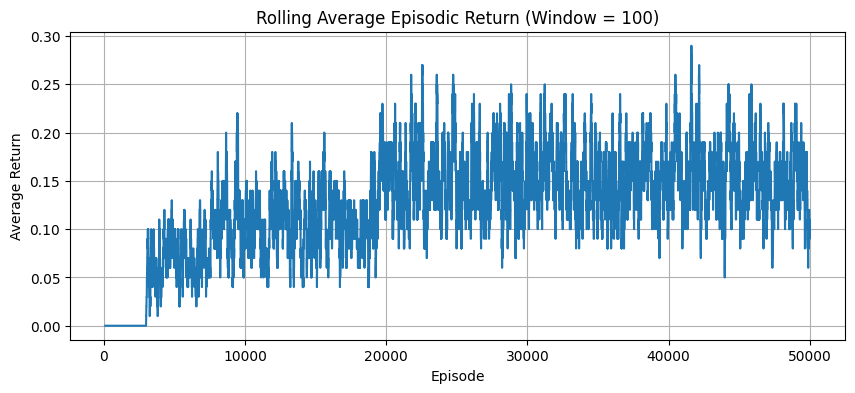

In [7]:
# Plot 1: Rolling Average Return
plt.figure(figsize=(10, 4))
plt.plot(range(rolling_window, n_episodes), rolling_avg)
plt.title("Rolling Average Episodic Return (Window = 100)")
plt.xlabel("Episode")
plt.ylabel("Average Return")
plt.grid()
plt.show()

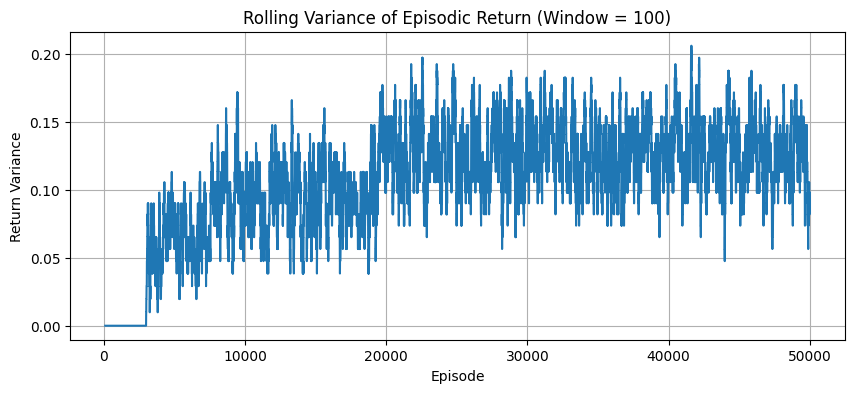

In [8]:
# Plot 2: Rolling Variance of Return
plt.figure(figsize=(10, 4))
plt.plot(range(rolling_window, n_episodes), variance_per_episode)
plt.title("Rolling Variance of Episodic Return (Window = 100)")
plt.xlabel("Episode")
plt.ylabel("Return Variance")
plt.grid()
plt.show()

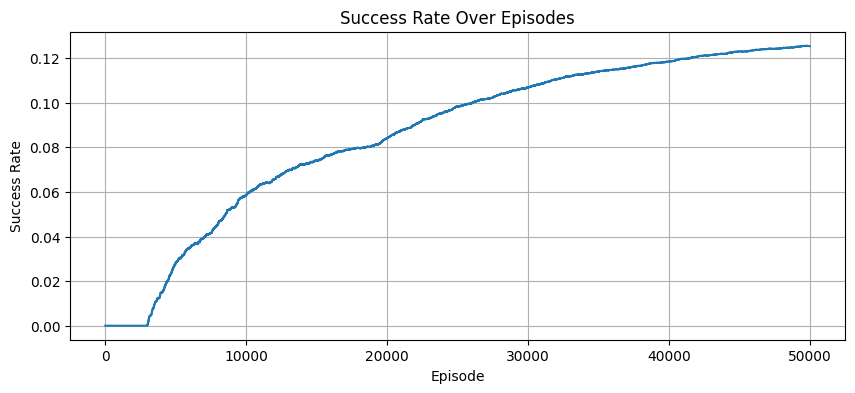

In [9]:
# Plot 3: Success Rate
plt.figure(figsize=(10, 4))
plt.plot(success_rate)
plt.title("Success Rate Over Episodes")
plt.xlabel("Episode")
plt.ylabel("Success Rate")
plt.grid()
plt.show()

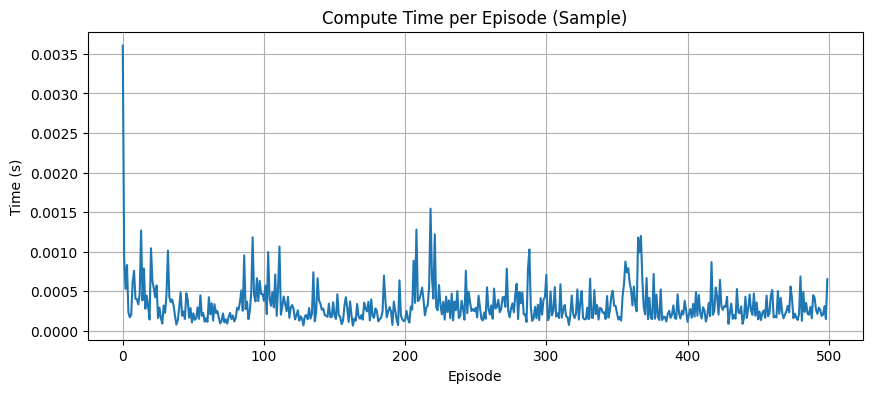

In [10]:
# Plot 4: Compute Time per Episode
plt.figure(figsize=(10, 4))
plt.plot(episode_times[:500])  # First 500 for clarity
plt.title("Compute Time per Episode (Sample)")
plt.xlabel("Episode")
plt.ylabel("Time (s)")
plt.grid()
plt.show()

In [11]:
# Sample Efficiency Calculation
thresholds = [0.6, 0.7, 0.8, 0.9]  # 60% to 90% of max performance
best_avg_return = max(rolling_avg)
sample_efficiency = {}

for t in thresholds:
    target = t * best_avg_return
    for i, avg in enumerate(rolling_avg):
        if avg >= target:
            sample_efficiency[f"{int(t*100)}%"] = rolling_window + i
            break
    else:
        sample_efficiency[f"{int(t*100)}%"] = None  # Never reached


In [12]:
# Print sample efficiency
print("\n Sample Efficiency (Episodes to reach threshold):")
for k, v in sample_efficiency.items():
    if v:
        print(f" - {k} of max return reached at episode: {v}")
    else:
        print(f" - {k} of max return was never reached.")



 Sample Efficiency (Episodes to reach threshold):
 - 60% of max return reached at episode: 8069
 - 70% of max return reached at episode: 9431
 - 80% of max return reached at episode: 21751
 - 90% of max return reached at episode: 22550


In [13]:
# Plot Sample Efficiency
labels = list(sample_efficiency.keys())
values = [v if v else n_episodes for v in sample_efficiency.values()]

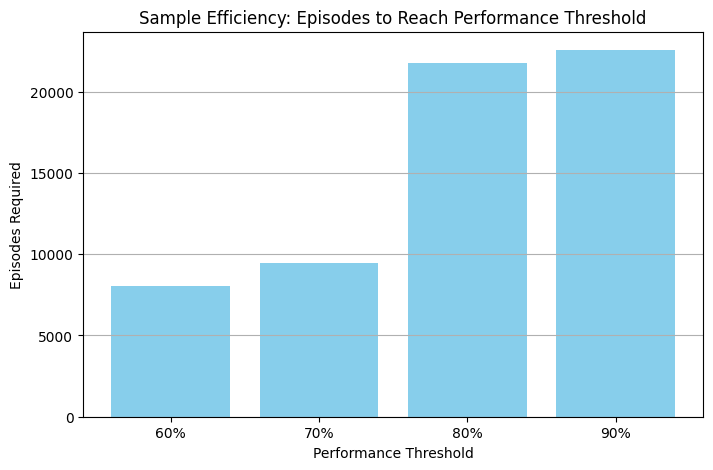

In [14]:
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, values, color='skyblue')
plt.title("Sample Efficiency: Episodes to Reach Performance Threshold")
plt.xlabel("Performance Threshold")
plt.ylabel("Episodes Required")
plt.grid(axis="y")


Multiple Evaluation Plots

**bold text**
i  visualized:

Rolling average return

Rolling variance

Success rate

Episode compute time

Sample efficiency bar chart


Above is the plots ,that i get after putting number of episodes =50k.Depending upon the its value ,its plots  also get varied.